In [35]:
#load data

import os                    
import skimage               
import numpy as np           
from skimage import data,transform
from skimage import img_as_float
from skimage.color import rgb2gray     
import matplotlib.pyplot as plt
import random      
from PIL import Image


def load_data(data_directory):
    directories=[d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory,d))]
    #d is every classification file
    labels=[]
    images=[]
    names=[]
    for d in directories:
        #get directions of each class
        label_directory=os.path.join(data_directory,d)
        file_names=[os.path.join(label_directory,f) for f in os.listdir(label_directory) if f.endswith(".jpeg") or f.endswith('.JPG') ]
        for f in file_names:

            img=skimage.data.imread(f, as_grey='True')
#             img[img>color] = 1
            images.append(img)  #read image
            labels.append(d)                   #read label
            names.append(f)
    return images,labels,names

#images and labels are list
# change the root path
ROOT_PATH="/Users/chenlingna/Desktop/Project/MelbourneCityTraining/StreetViewDownload/TensorFlowTrain"
color = 150/255
#data_directory="/Users/chenlingna/Desktop/Project/StreetViewDownload/TensorFlowTrain/Training"
# train_data_directory=os.path.join(ROOT_PATH,"Training")
# test_data_directory=os.path.join(ROOT_PATH,"Testing")
data_directory=os.path.join(ROOT_PATH,"Training")



In [36]:
#Load Data Set
images_Total,labels_Total,names_Total=load_data(data_directory)


In [37]:
from sklearn.model_selection import train_test_split
images, test_images, labels, test_labels, names, test_names  = train_test_split(images_Total, labels_Total, names_Total, test_size=0.1, random_state=90051)

In [38]:
#Load Training Set
# images,labels,names=load_data(train_data_directory)

images28=[]
for img in images:
#     img[img>color]=1
#     img[img<color]=0
    images28.append(img)
    
# Rescale the images in the `images` array
images28 = [transform.resize(image, (28, 28)) for image in images28]
# Convert `images28` to an array
images28 = np.array(images28)
# # Convert `images` to grayscale
# images28 = rgb2gray(images28)





/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [39]:
#Load Testing Set
# test_images, test_labels, test_names = load_data(test_data_directory)

test_images28=[]
for img in test_images:
#     img[img>color]=1
#     img[img<color]=0
    test_images28.append(img)

# Transform the images to 28 by 28 pixels
test_images28 = [transform.resize(image, (28, 28)) for image in test_images28]
test_images28 = np.array(test_images28)
# # Convert to grayscale
# from skimage.color import rgb2gray

# test_images28 = rgb2gray(np.array(test_images28))


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [40]:
class DatasetIterator:
    """
    An iterator that returns randomized batches from a data set (with features and labels)
    """
    def __init__(self, features, labels, batch_size):
        assert(features.shape[0]==labels.shape[0])
        assert(batch_size > 0 and batch_size <= features.shape[0])
        self.features = features
        self.labels = labels
        self.num_instances = features.shape[0]
        self.batch_size = batch_size
        self.num_batches = self.num_instances//self.batch_size
        if (self.num_instances%self.batch_size!=0):
            self.num_batches += 1
        self._i = 0
        self._rand_ids = None

    def __iter__(self):
        self._i = 0
        self._rand_ids = np.random.permutation(self.num_instances)
        return self
    
    def next(self):
        self.__next__(self)
    
    def __next__(self):
        if self.num_instances - self._i >= self.batch_size:
            this_rand_ids = self._rand_ids[self._i:self._i + self.batch_size]
            self._i += self.batch_size
            return self.features[this_rand_ids], self.labels[this_rand_ids]
        elif self.num_instances - self._i > 0:
            this_rand_ids = self._rand_ids[self._i::]
            self._i = self.num_instances
            return self.features[this_rand_ids], self.labels[this_rand_ids]
        else:
            raise StopIteration()
            
batch_size = 100
labels=np.array(labels)
train_iterator = DatasetIterator(images28, labels, batch_size)

In [41]:
#CNN
import tensorflow as tf
IM_WIDTH = images28.shape[1]      # width of an image in pixels
IM_HEIGHT = images28.shape[2] 
NUM_CLASSES = 2
tf.reset_default_graph()
with tf.variable_scope('input'):
    X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='image')
    Y = tf.placeholder(tf.int32, [None], name='label')
    
DEPTH_C1 = 8       # depth of convolutional layer #1
DEPTH_C2 = 16      # depth of convolutional layer #2
UNITS_D1 = 256     # number of neurons in dense layer #1
with tf.variable_scope('cnn_model'):
    # Boolean placeholder which is set to True for training, and False for inference.
    # This is required to implement dropout. 
    training_mode = tf.placeholder(dtype=tf.bool, name='training_mode')
    
    # Input Layer
    input_layer = tf.reshape(X, [-1, IM_WIDTH, IM_HEIGHT, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=DEPTH_C1, kernel_size=[5, 5], 
                             padding='same', activation=tf.nn.relu, use_bias=True, 
                             name='conv_layer_1')

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2, 
                                    name='pool_layer_1')

    # Convolutional Layer #2 
    conv2 = tf.layers.conv2d(inputs=pool1, filters=DEPTH_C2, kernel_size=[5, 5], 
                             padding='same', activation=tf.nn.relu, use_bias=True, 
                             name='conv_layer_2') # fill in

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2, 
                                    name='pool_layer_2') # fill in

    # Dense Layer #1
    pool2_flat = tf.reshape(pool2, shape=[-1, 7*7*DEPTH_C2], name='pool_layer_2_flat')
    dense = tf.layers.dense(inputs=pool2_flat, units=UNITS_D1, activation=tf.nn.relu, 
                            name='dense_layer_1')
    dropout = tf.layers.dropout(inputs=dense, rate=0.7, training=training_mode, name='dropout')

    # Dense Layer #2 (Logits Layer)
    logits = tf.layers.dense(inputs=dropout, units=NUM_CLASSES, use_bias=True,
                             name='dense_layer_2')
    
    # Predicted labels
    predictions = tf.argmax(logits, axis=1)

In [42]:
with tf.variable_scope('loss'):
    loss = tf.losses.sparse_softmax_cross_entropy(labels=Y, logits=logits)
with tf.variable_scope('train'):
    opt = tf.train.AdamOptimizer(learning_rate=0.001)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = opt.minimize(loss=loss, global_step=global_step)

In [43]:
with tf.variable_scope('evaluation'):
    acc, acc_op = tf.metrics.accuracy(labels=Y, predictions=predictions, name='accuracy')
    loss_summary = tf.summary.scalar('loss', loss)
    acc_summary = tf.summary.scalar('accuracy', acc)
    eval_summaries = tf.summary.merge([loss_summary, acc_summary])

In [44]:
with tf.variable_scope('cnn_model/conv_layer_1', reuse=True):
    kernel = tf.get_variable('kernel')
    with tf.variable_scope('visualization'):
        # scale weights to [0 1]
        x_min = tf.reduce_min(kernel)
        x_max = tf.reduce_max(kernel)
        kernel_0_to_1 = (kernel - x_min) / (x_max - x_min)

        # to tf.summary.image format
        kernel_transposed = tf.transpose(kernel_0_to_1, [3, 0, 1, 2])

        # this will display 5 filters from the 8 in conv_layer_1
        filter_summary = tf.summary.image('filters', kernel_transposed, max_outputs=5)

In [45]:
LOG_DIR = os.path.join(os.curdir, 'parkingSign_log')
NUM_EPOCHS = 2000
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
# with tf.Session() as sess:
sess=tf.Session()
sess.run(init)
# Instantiate writers for TensorBoard (for saving serialized summaries to disk)
train_summary_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'train'), sess.graph)
test_summary_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'test'), sess.graph)
# Run optimizer for multiple epochs
for epoch in range(NUM_EPOCHS):
    print("Starting epoch {}.".format(epoch))
    for X_batch, Y_batch in train_iterator:
        # Run a training step
        _, step = sess.run([train_op, global_step],
                           feed_dict={X: X_batch, Y: Y_batch, training_mode: True})
        # Every 100 batches compute the accuracy on the training set and save the filters in the first convolutional layer
        if (step % 100 == 0 and step > 0):
            train_accuracy, eval_s, filter_s = sess.run([acc_op, eval_summaries, filter_summary], 
                              feed_dict={X: images28, Y: labels, training_mode: False})
            train_summary_writer.add_summary(eval_s, global_step=step)
            train_summary_writer.add_summary(filter_s, global_step=step)
            print("\tTraining accuracy at step {}: {}.".format(step, train_accuracy))
        # Every 10 batches compute the accuracy on the test set.
        if (step % 10 == 0):
            test_accuracy, eval_s = sess.run([acc_op, eval_summaries], 
                             feed_dict={X: test_images28, Y: test_labels, training_mode: False})
            test_summary_writer.add_summary(eval_s, global_step=step)
print("Optimization complete.")
train_summary_writer.close()
test_summary_writer.close()

Starting epoch 0.
Starting epoch 1.
	Training accuracy at step 100: 0.7277555465698242.
Starting epoch 2.
Starting epoch 3.
	Training accuracy at step 200: 0.7617389559745789.
Starting epoch 4.
	Training accuracy at step 300: 0.7911677360534668.
Starting epoch 5.
Starting epoch 6.
	Training accuracy at step 400: 0.8138508200645447.
Starting epoch 7.
	Training accuracy at step 500: 0.8304445147514343.
Starting epoch 8.
Starting epoch 9.
	Training accuracy at step 600: 0.8438856601715088.
Starting epoch 10.
	Training accuracy at step 700: 0.8538666367530823.
Starting epoch 11.
Starting epoch 12.
	Training accuracy at step 800: 0.863868236541748.
Starting epoch 13.
	Training accuracy at step 900: 0.8718216419219971.
Starting epoch 14.
Starting epoch 15.
	Training accuracy at step 1000: 0.8787989616394043.
Starting epoch 16.
	Training accuracy at step 1100: 0.8850611448287964.
Starting epoch 17.
Starting epoch 18.
	Training accuracy at step 1200: 0.8906046152114868.
Starting epoch 19.
	Tra

	Training accuracy at step 10000: 0.9604049921035767.
Starting epoch 154.
Starting epoch 155.
	Training accuracy at step 10100: 0.9605162143707275.
Starting epoch 156.
	Training accuracy at step 10200: 0.9606317281723022.
Starting epoch 157.
Starting epoch 158.
	Training accuracy at step 10300: 0.9607322216033936.
Starting epoch 159.
	Training accuracy at step 10400: 0.96084064245224.
Starting epoch 160.
Starting epoch 161.
	Training accuracy at step 10500: 0.9609351754188538.
Starting epoch 162.
Starting epoch 163.
	Training accuracy at step 10600: 0.9610258340835571.
Starting epoch 164.
	Training accuracy at step 10700: 0.9611318111419678.
Starting epoch 165.
Starting epoch 166.
	Training accuracy at step 10800: 0.961266279220581.
Starting epoch 167.
	Training accuracy at step 10900: 0.9613815546035767.
Starting epoch 168.
Starting epoch 169.
	Training accuracy at step 11000: 0.9615006446838379.
Starting epoch 170.
	Training accuracy at step 11100: 0.961602509021759.
Starting epoch 1

Starting epoch 303.
	Training accuracy at step 19700: 0.9667774438858032.
Starting epoch 304.
	Training accuracy at step 19800: 0.9668096899986267.
Starting epoch 305.
Starting epoch 306.
	Training accuracy at step 19900: 0.9668369293212891.
Starting epoch 307.
	Training accuracy at step 20000: 0.9668532609939575.
Starting epoch 308.
Starting epoch 309.
	Training accuracy at step 20100: 0.9668799638748169.
Starting epoch 310.
	Training accuracy at step 20200: 0.9668883085250854.
Starting epoch 311.
Starting epoch 312.
	Training accuracy at step 20300: 0.9669138789176941.
Starting epoch 313.
	Training accuracy at step 20400: 0.9669448733329773.
Starting epoch 314.
Starting epoch 315.
	Training accuracy at step 20500: 0.9669720530509949.
Starting epoch 316.
	Training accuracy at step 20600: 0.966992199420929.
Starting epoch 317.
Starting epoch 318.
	Training accuracy at step 20700: 0.9670054912567139.
Starting epoch 319.
	Training accuracy at step 20800: 0.9670473337173462.
Starting epoc

Starting epoch 452.
	Training accuracy at step 29400: 0.9689342379570007.
Starting epoch 453.
	Training accuracy at step 29500: 0.9689610004425049.
Starting epoch 454.
Starting epoch 455.
	Training accuracy at step 29600: 0.9689882397651672.
Starting epoch 456.
	Training accuracy at step 29700: 0.9689939618110657.
Starting epoch 457.
Starting epoch 458.
	Training accuracy at step 29800: 0.9690026044845581.
Starting epoch 459.
	Training accuracy at step 29900: 0.9690079689025879.
Starting epoch 460.
Starting epoch 461.
	Training accuracy at step 30000: 0.969031810760498.
Starting epoch 462.
Starting epoch 463.
	Training accuracy at step 30100: 0.9690583944320679.
Starting epoch 464.
	Training accuracy at step 30200: 0.969078004360199.
Starting epoch 465.
Starting epoch 466.
	Training accuracy at step 30300: 0.9690934419631958.
Starting epoch 467.
	Training accuracy at step 30400: 0.9691092371940613.
Starting epoch 468.
Starting epoch 469.
	Training accuracy at step 30500: 0.969124674797

Starting epoch 601.
	Training accuracy at step 39100: 0.9704235196113586.
Starting epoch 602.
Starting epoch 603.
	Training accuracy at step 39200: 0.9704403281211853.
Starting epoch 604.
	Training accuracy at step 39300: 0.9704489707946777.
Starting epoch 605.
Starting epoch 606.
	Training accuracy at step 39400: 0.9704703092575073.
Starting epoch 607.
	Training accuracy at step 39500: 0.9704933762550354.
Starting epoch 608.
Starting epoch 609.
	Training accuracy at step 39600: 0.9705222249031067.
Starting epoch 610.
	Training accuracy at step 39700: 0.9705469012260437.
Starting epoch 611.
Starting epoch 612.
	Training accuracy at step 39800: 0.9705615043640137.
Starting epoch 613.
	Training accuracy at step 39900: 0.970572829246521.
Starting epoch 614.
Starting epoch 615.
	Training accuracy at step 40000: 0.9705847501754761.
Starting epoch 616.
	Training accuracy at step 40100: 0.9705997705459595.
Starting epoch 617.
Starting epoch 618.
	Training accuracy at step 40200: 0.97061049938

Starting epoch 750.
	Training accuracy at step 48800: 0.971305251121521.
Starting epoch 751.
Starting epoch 752.
	Training accuracy at step 48900: 0.9713190197944641.
Starting epoch 753.
	Training accuracy at step 49000: 0.9713354706764221.
Starting epoch 754.
Starting epoch 755.
	Training accuracy at step 49100: 0.9713501930236816.
Starting epoch 756.
	Training accuracy at step 49200: 0.971363365650177.
Starting epoch 757.
Starting epoch 758.
	Training accuracy at step 49300: 0.9713746905326843.
Starting epoch 759.
	Training accuracy at step 49400: 0.9713819026947021.
Starting epoch 760.
Starting epoch 761.
	Training accuracy at step 49500: 0.9713847637176514.
Starting epoch 762.
Starting epoch 763.
	Training accuracy at step 49600: 0.9713956713676453.
Starting epoch 764.
	Training accuracy at step 49700: 0.971400260925293.
Starting epoch 765.
Starting epoch 766.
	Training accuracy at step 49800: 0.9714086651802063.
Starting epoch 767.
	Training accuracy at step 49900: 0.9714165329933

Starting epoch 899.
	Training accuracy at step 58500: 0.9721707701683044.
Starting epoch 900.
Starting epoch 901.
	Training accuracy at step 58600: 0.9721766114234924.
Starting epoch 902.
Starting epoch 903.
	Training accuracy at step 58700: 0.9721810221672058.
Starting epoch 904.
	Training accuracy at step 58800: 0.9721927642822266.
Starting epoch 905.
Starting epoch 906.
	Training accuracy at step 58900: 0.9721965193748474.
Starting epoch 907.
	Training accuracy at step 59000: 0.9722025990486145.
Starting epoch 908.
Starting epoch 909.
	Training accuracy at step 59100: 0.9722132086753845.
Starting epoch 910.
	Training accuracy at step 59200: 0.9722165465354919.
Starting epoch 911.
Starting epoch 912.
	Training accuracy at step 59300: 0.9722224473953247.
Starting epoch 913.
	Training accuracy at step 59400: 0.9722324013710022.
Starting epoch 914.
Starting epoch 915.
	Training accuracy at step 59500: 0.9722415804862976.
Starting epoch 916.
	Training accuracy at step 59600: 0.9722461700

	Training accuracy at step 68100: 0.9725875854492188.
Starting epoch 1048.
Starting epoch 1049.
	Training accuracy at step 68200: 0.9725902676582336.
Starting epoch 1050.
	Training accuracy at step 68300: 0.9725950360298157.
Starting epoch 1051.
Starting epoch 1052.
	Training accuracy at step 68400: 0.9726039171218872.
Starting epoch 1053.
	Training accuracy at step 68500: 0.9726117253303528.
Starting epoch 1054.
Starting epoch 1055.
	Training accuracy at step 68600: 0.9726219177246094.
Starting epoch 1056.
	Training accuracy at step 68700: 0.9726343750953674.
Starting epoch 1057.
Starting epoch 1058.
	Training accuracy at step 68800: 0.9726423621177673.
Starting epoch 1059.
	Training accuracy at step 68900: 0.9726523160934448.
Starting epoch 1060.
Starting epoch 1061.
	Training accuracy at step 69000: 0.9726572036743164.
Starting epoch 1062.
Starting epoch 1063.
	Training accuracy at step 69100: 0.9726645946502686.
Starting epoch 1064.
	Training accuracy at step 69200: 0.9726731181144

Starting epoch 1194.
Starting epoch 1195.
	Training accuracy at step 77700: 0.9730038046836853.
Starting epoch 1196.
	Training accuracy at step 77800: 0.9730096459388733.
Starting epoch 1197.
Starting epoch 1198.
	Training accuracy at step 77900: 0.973017156124115.
Starting epoch 1199.
	Training accuracy at step 78000: 0.9730197787284851.
Starting epoch 1200.
Starting epoch 1201.
	Training accuracy at step 78100: 0.9730241298675537.
Starting epoch 1202.
Starting epoch 1203.
	Training accuracy at step 78200: 0.9730269312858582.
Starting epoch 1204.
	Training accuracy at step 78300: 0.9730270504951477.
Starting epoch 1205.
Starting epoch 1206.
	Training accuracy at step 78400: 0.9730269312858582.
Starting epoch 1207.
	Training accuracy at step 78500: 0.9730304479598999.
Starting epoch 1208.
Starting epoch 1209.
	Training accuracy at step 78600: 0.973034143447876.
Starting epoch 1210.
	Training accuracy at step 78700: 0.9730373024940491.
Starting epoch 1211.
Starting epoch 1212.
	Training

Starting epoch 1341.
	Training accuracy at step 87200: 0.9733725786209106.
Starting epoch 1342.
Starting epoch 1343.
	Training accuracy at step 87300: 0.9733818173408508.
Starting epoch 1344.
	Training accuracy at step 87400: 0.9733880758285522.
Starting epoch 1345.
Starting epoch 1346.
	Training accuracy at step 87500: 0.973391592502594.
Starting epoch 1347.
	Training accuracy at step 87600: 0.9733980894088745.
Starting epoch 1348.
Starting epoch 1349.
	Training accuracy at step 87700: 0.9734019041061401.
Starting epoch 1350.
	Training accuracy at step 87800: 0.9734077453613281.
Starting epoch 1351.
Starting epoch 1352.
	Training accuracy at step 87900: 0.9734084010124207.
Starting epoch 1353.
	Training accuracy at step 88000: 0.9734150767326355.
Starting epoch 1354.
Starting epoch 1355.
	Training accuracy at step 88100: 0.9734230637550354.
Starting epoch 1356.
	Training accuracy at step 88200: 0.9734280705451965.
Starting epoch 1357.
Starting epoch 1358.
	Training accuracy at step 88

	Training accuracy at step 96700: 0.9737059473991394.
Starting epoch 1488.
Starting epoch 1489.
	Training accuracy at step 96800: 0.973708987236023.
Starting epoch 1490.
	Training accuracy at step 96900: 0.9737131595611572.
Starting epoch 1491.
Starting epoch 1492.
	Training accuracy at step 97000: 0.9737167358398438.
Starting epoch 1493.
	Training accuracy at step 97100: 0.9737219214439392.
Starting epoch 1494.
Starting epoch 1495.
	Training accuracy at step 97200: 0.9737234115600586.
Starting epoch 1496.
	Training accuracy at step 97300: 0.9737253189086914.
Starting epoch 1497.
Starting epoch 1498.
	Training accuracy at step 97400: 0.9737290740013123.
Starting epoch 1499.
	Training accuracy at step 97500: 0.9737312197685242.
Starting epoch 1500.
Starting epoch 1501.
	Training accuracy at step 97600: 0.9737347364425659.
Starting epoch 1502.
Starting epoch 1503.
	Training accuracy at step 97700: 0.9737396836280823.
Starting epoch 1504.
	Training accuracy at step 97800: 0.97374206781387

Starting epoch 1633.
	Training accuracy at step 106200: 0.9739669561386108.
Starting epoch 1634.
Starting epoch 1635.
	Training accuracy at step 106300: 0.9739661812782288.
Starting epoch 1636.
	Training accuracy at step 106400: 0.9739676117897034.
Starting epoch 1637.
Starting epoch 1638.
	Training accuracy at step 106500: 0.9739722013473511.
Starting epoch 1639.
	Training accuracy at step 106600: 0.973973274230957.
Starting epoch 1640.
Starting epoch 1641.
	Training accuracy at step 106700: 0.9739750027656555.
Starting epoch 1642.
Starting epoch 1643.
	Training accuracy at step 106800: 0.9739792943000793.
Starting epoch 1644.
	Training accuracy at step 106900: 0.9739817380905151.
Starting epoch 1645.
Starting epoch 1646.
	Training accuracy at step 107000: 0.9739810824394226.
Starting epoch 1647.
	Training accuracy at step 107100: 0.9739802479743958.
Starting epoch 1648.
Starting epoch 1649.
	Training accuracy at step 107200: 0.9739829897880554.
Starting epoch 1650.
	Training accuracy

Starting epoch 1778.
	Training accuracy at step 115600: 0.974125325679779.
Starting epoch 1779.
	Training accuracy at step 115700: 0.9741268157958984.
Starting epoch 1780.
Starting epoch 1781.
	Training accuracy at step 115800: 0.974129319190979.
Starting epoch 1782.
Starting epoch 1783.
	Training accuracy at step 115900: 0.9741320013999939.
Starting epoch 1784.
	Training accuracy at step 116000: 0.9741299152374268.
Starting epoch 1785.
Starting epoch 1786.
	Training accuracy at step 116100: 0.9741283059120178.
Starting epoch 1787.
	Training accuracy at step 116200: 0.9741286635398865.
Starting epoch 1788.
Starting epoch 1789.
	Training accuracy at step 116300: 0.9741288423538208.
Starting epoch 1790.
	Training accuracy at step 116400: 0.9741308093070984.
Starting epoch 1791.
Starting epoch 1792.
	Training accuracy at step 116500: 0.9741332530975342.
Starting epoch 1793.
	Training accuracy at step 116600: 0.9741349220275879.
Starting epoch 1794.
Starting epoch 1795.
	Training accuracy 

Starting epoch 1923.
	Training accuracy at step 125000: 0.9742465019226074.
Starting epoch 1924.
	Training accuracy at step 125100: 0.9742493629455566.
Starting epoch 1925.
Starting epoch 1926.
	Training accuracy at step 125200: 0.9742498993873596.
Starting epoch 1927.
	Training accuracy at step 125300: 0.9742515683174133.
Starting epoch 1928.
Starting epoch 1929.
	Training accuracy at step 125400: 0.9742534756660461.
Starting epoch 1930.
	Training accuracy at step 125500: 0.9742525219917297.
Starting epoch 1931.
Starting epoch 1932.
	Training accuracy at step 125600: 0.9742544889450073.
Starting epoch 1933.
	Training accuracy at step 125700: 0.9742565155029297.
Starting epoch 1934.
Starting epoch 1935.
	Training accuracy at step 125800: 0.974259614944458.
Starting epoch 1936.
	Training accuracy at step 125900: 0.9742615222930908.
Starting epoch 1937.
Starting epoch 1938.
	Training accuracy at step 126000: 0.9742631912231445.
Starting epoch 1939.
	Training accuracy at step 126100: 0.97

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
[0 0 0 0 0 0 0 0 0 0]


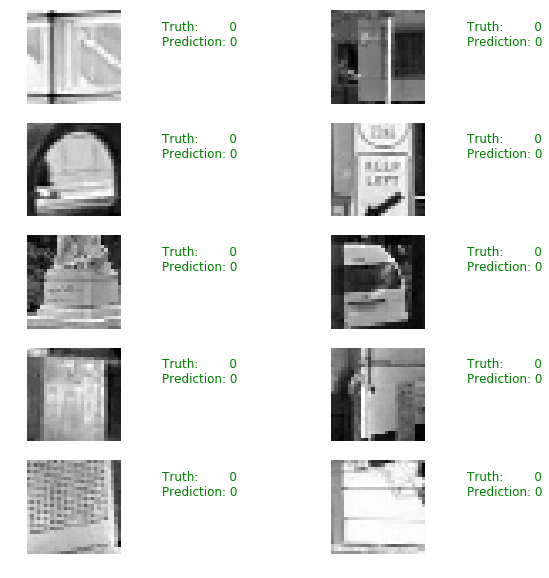

In [20]:
# Import `matplotlib`
import matplotlib.pyplot as plt
import random
# Pick 10 random images
sample_indexes = random.sample(range(len(images28)), 10) 
sample_images = [images28[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]


# Run the "correct_pred" operation
predicted = sess.run([predictions], feed_dict={X: sample_images, training_mode: False})[0]
# Print the real and predicted labels
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2, 1 + i)
    plt.axis('off')
    color = 'green' if int(truth) == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
             fontsize=12, color=color)
    plt.imshow(sample_images[i], cmap="gray")

plt.show()

In [46]:
# Run predictions against the full test set.

predicted = sess.run([predictions], feed_dict={X: test_images28, training_mode: False})[0]
print(predicted)
print(len(predicted))
# # Calculate correct matches
# match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])

# # Calculate the accuracy
# accuracy = match_count / len(test_labels)

# # Print the accuracy
# print("Accuracy: {:.3f}".format(accuracy))

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1
 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0
 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1
 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0
 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 0 0 0 0 0 1 0 

In [47]:
np.sum(predicted)

280

In [48]:
def precision(labels, predicted):
    FP=0
    TP=0
    for i in range(len(labels)):
        if labels[i]=='1' and predicted[i]==1:
            TP+=1
        if labels[i]=='0' and predicted[i]==1:
            FP+=1
    print(TP)
    print(FP)
    return TP/(TP+FP)

#         scipy.misc.imsave("/Users/chenlingna/Desktop/output/"+str(i)+".JPG", test_images[i])

In [49]:
def recall(labels, predicted):
    FN=0
    TP=0
    for i in range(len(labels)):
        if labels[i]=='1' and predicted[i]==1:
            TP+=1
        if labels[i]=='1' and predicted[i]==0:
            FN+=1
    print("FN:")
    print(FN)
    return TP/(TP+FN)

In [50]:
# Calculate correct matches
match_count = sum([int(int(y) == y_) for y, y_ in zip(test_labels, predicted)])
print(match_count)
# Calculate the accuracy
accuracy = match_count / len(test_labels)

# Print the accuracy
print("Accuracy: {:.3f}".format(accuracy))
# Print the recall and precision
print("Recall: {:3f}".format(recall(test_labels, predicted)))
print("Precision: {:3f}".format(precision(test_labels, predicted)))

695
Accuracy: 0.963
FN:
14
Recall: 0.950178
267
13
Precision: 0.953571


In [52]:
#Load output
output_data_directory="/Users/chenlingna/Desktop/Geelong_Stage1"
output_images, output_labels, output_names = load_data(output_data_directory)

output_images28=[]
for img in output_images:
#     img[img>color]=1
#     img[img<color]=0
    output_images28.append(img)

# Transform the images to 28 by 28 pixels
output_images28 = [transform.resize(image, (28, 28)) for image in output_images28]
output_images28 = np.array(output_images28)

# Run predictions against the output set.
predicted = sess.run([predictions], feed_dict={X: output_images28, training_mode: False})[0]


# Calculate correct matches
match_count = sum([int(int(y) == y_) for y, y_ in zip(output_labels, predicted)])
# Calculate the accuracy
accuracy = match_count / len(output_labels)

# Print the accuracy
print("Accuracy: {:.3f}".format(accuracy))
# Print the recall and precision
print("Recall: {:3f}".format(recall(output_labels, predicted)))
print("Precision: {:3f}".format(precision(output_labels, predicted)))

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Accuracy: 0.902
FN:
1567
Recall: 0.170021
321
502
Precision: 0.390036


In [53]:
np.sum(predicted)

823

In [54]:
#output the related images
import scipy.misc
for i in range(len(output_images28)):
    if predicted[i]==1:
        name=output_names[i].split('/')[-1]
        scipy.misc.imsave("/Users/chenlingna/Desktop/output-F/"+name, skimage.data.imread(output_names[i]))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """
